![tower_bridge](../misc/tower_bridge.jpeg)

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [28]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in the data
weather = pd.read_csv("../data/london_weather.csv")

# Start coding here
# Use as many cells as you like

**1. Loading the data.**
- Load the data from london_weather.csv to understand its contents.
- Reading in the data.
- Determine the column names, data types, number of null values.

In [29]:
weather # read in the data

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN


In [30]:
weather.info() # check the data types and null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [31]:
weather.isnull().sum() # check the null values

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

**2. Data cleaning**
- Convert columns to the correct data type to enable exploratory data analysis.
- Working with the date column.
- Extracting more date information.

In [32]:
weather['date'] = pd.to_datetime(weather['date'].astype(str), format="%Y%m%d") # convert the date column to datetime
weather['year'] = weather['date'].dt.year # extract the year from the date column
weather['month'] = weather['date'].dt.month # extract the month from the date column

**3. Exploratory Data Analysis**
- Explore the data by visualizing some of the features.
- Visuzalizing temperature.

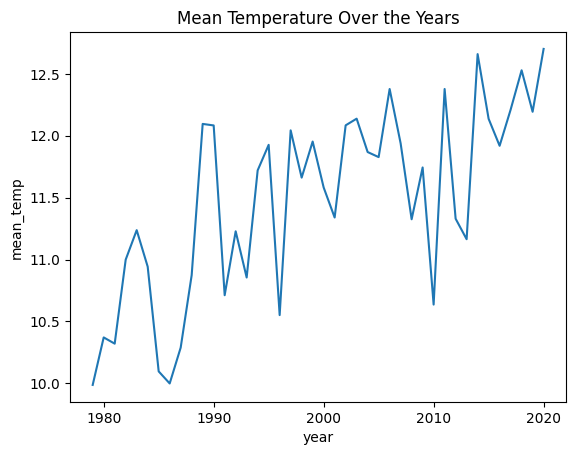

<Figure size 1200x1200 with 0 Axes>

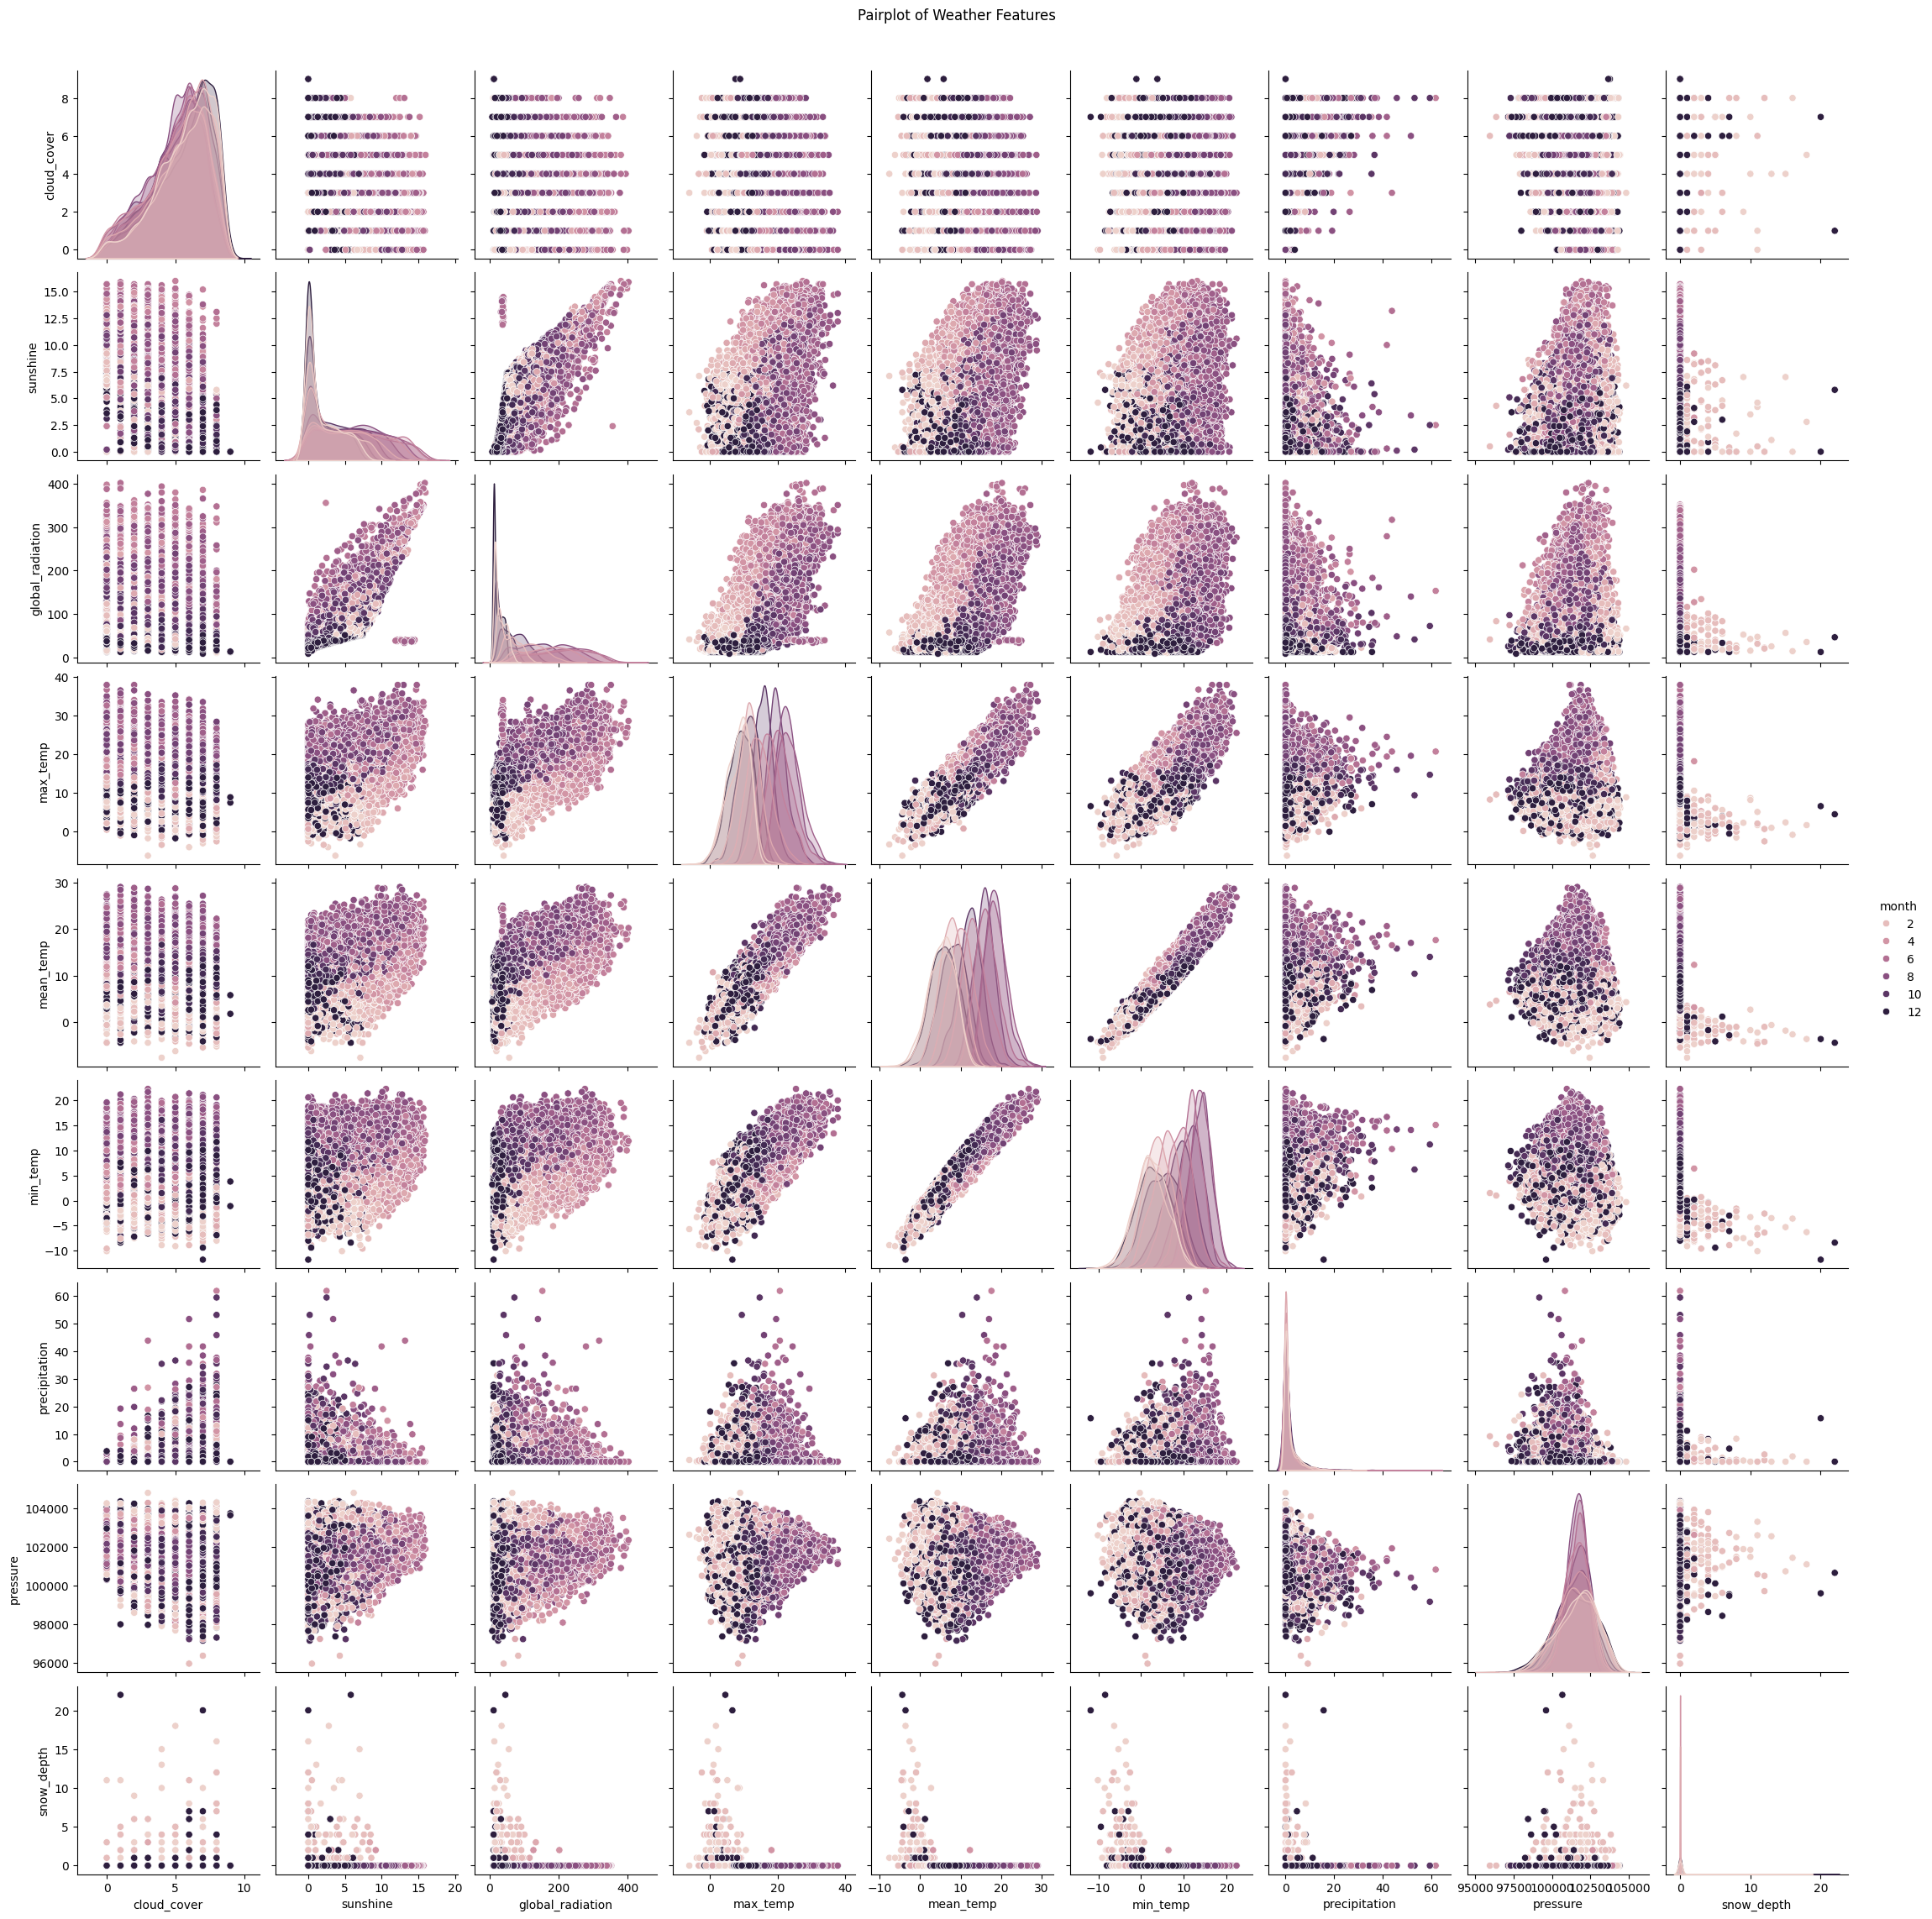

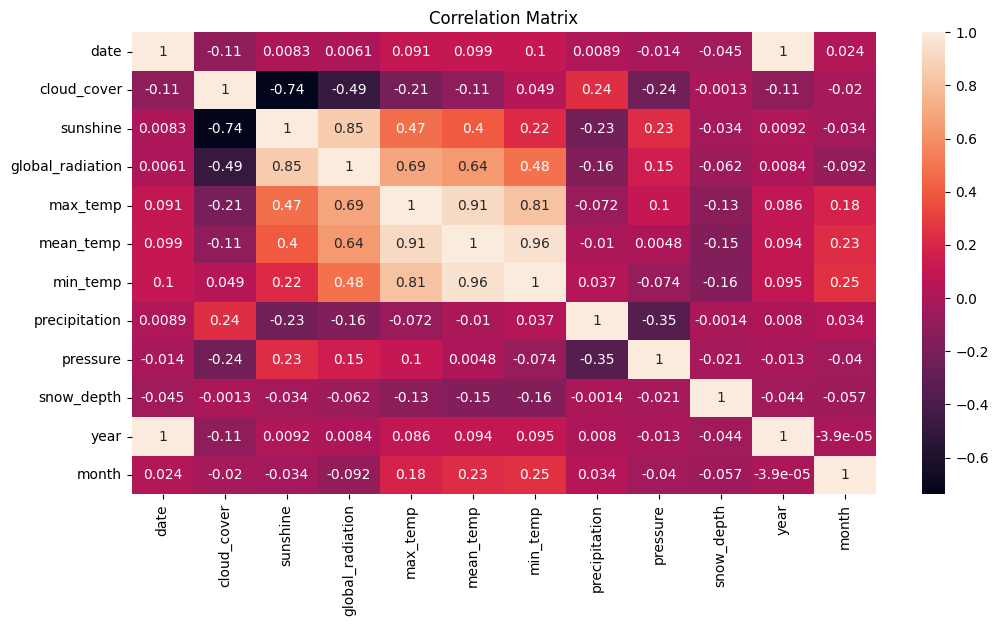

In [ ]:
# mean temperature over the years
mean_temp_graph = weather.groupby('year')['mean_temp'].mean().reset_index()
sns.lineplot(x="year", y="mean_temp", data=mean_temp_graph)
plt.title('Mean Temperature Over the Years')
plt.show()

# test out pairplot
plt.figure(figsize=(12, 12))
sns.pairplot(weather, vars=['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth'], hue='month')
plt.suptitle('Pairplot of Weather Features', y=1.02)
plt.show()

# correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(weather.corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

**4. Feature Selection**
- Choose appropriate features to predict the mean temperature.
- Filter features.

In [34]:
feature_selection = ['max_temp', 'sunshine', 'global_radiation', 'month', 'cloud_cover', 'precipitation']
weather = weather.dropna(subset=['mean_temp']) # drop rows with null values in the target variable

x = weather[feature_selection] 
y = weather['mean_temp'] # target variable

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # split the dataset

**5. Preprocess data**
- Use an imputer to account for missing values, then normalize the features using the scaler. Make sure to split the data into train and test samples at the right moment. These preprocessing steps should go into a pipeline.
- Imputing and normalizing data.

In [36]:
# impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

# scale the features
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

**6. Machine learning training and evaluation**
- Try out regression models such as linear regression, decision tree, and random forest regressors, with various hyperparameters, to find the best performing model. Log all of your models and metrics using MLflow.
- Building a for loop to try different hyperparameters.
- Logging and evaluating.

In [37]:
# Predict, evaluate, and log the parameters and metrics of your models
input_example = x_test[0:1] # example input for the model

for idx, depth in enumerate([1, 2, 10]): 
    run_name = f"run_{idx}"
    with mlflow.start_run(run_name=run_name):
        # Create models
        lin_reg = LinearRegression().fit(x_train, y_train)
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(x_train, y_train)
        forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(x_train, y_train)
        
        # Log models
        mlflow.sklearn.log_model(lin_reg, "lin_reg", input_example=input_example)
        mlflow.sklearn.log_model(tree_reg, "tree_reg", input_example=input_example)
        mlflow.sklearn.log_model(forest_reg, "forest_reg", input_example=input_example)
        
        # Evaluate performance
        y_pred_lin_reg = lin_reg.predict(x_test)
        lin_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin_reg))
        y_pred_tree_reg = tree_reg.predict(x_test)
        tree_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree_reg))
        y_pred_forest_reg = forest_reg.predict(x_test)
        forest_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_forest_reg))
        
        # Log performance
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_lr", lin_reg_rmse)
        mlflow.log_metric("rmse_tr", tree_reg_rmse)
        mlflow.log_metric("rmse_fr", forest_reg_rmse)


**7. Searching your logged results**
- Create a variable called `experiment_results` containing all logged data relating to your MLflow runs.
- Searching runs.

In [38]:
experiment_results = mlflow.search_runs()
experiment_results

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_lr,metrics.rmse_fr,metrics.rmse_tr,params.max_depth,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.user
0,874ed308ffb7469cbd4afbcb6ac75950,0,FINISHED,file:///c:/Users/Juls/Desktop/dsml-projects/Lo...,2025-05-03 04:08:44.902000+00:00,2025-05-03 04:09:04.358000+00:00,2.224481,2.120049,2.321137,10,LOCAL,"[{""run_id"": ""874ed308ffb7469cbd4afbcb6ac75950""...",c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\...,run_2,Juls
1,9215096719f041b9a2127a7eded5d088,0,FINISHED,file:///c:/Users/Juls/Desktop/dsml-projects/Lo...,2025-05-03 04:08:28.307000+00:00,2025-05-03 04:08:44.891000+00:00,2.224481,2.723244,2.796776,2,LOCAL,"[{""run_id"": ""9215096719f041b9a2127a7eded5d088""...",c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\...,run_1,Juls
2,0e00379098b840658963988cd72a0e9a,0,FINISHED,file:///c:/Users/Juls/Desktop/dsml-projects/Lo...,2025-05-03 04:08:12.347000+00:00,2025-05-03 04:08:28.300000+00:00,2.224481,3.550774,3.585152,1,LOCAL,"[{""run_id"": ""0e00379098b840658963988cd72a0e9a""...",c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\...,run_0,Juls
3,543a8761879c4cb78f1741738e3bbb42,0,FINISHED,file:///c:/Users/Juls/Desktop/dsml-projects/Lo...,2025-05-03 04:04:43.383000+00:00,2025-05-03 04:05:01.550000+00:00,2.224481,2.120049,2.321137,10,LOCAL,"[{""run_id"": ""543a8761879c4cb78f1741738e3bbb42""...",c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\...,run_2,Juls
4,1fbc1491dce449ebb3660bc6ed771c16,0,FINISHED,file:///c:/Users/Juls/Desktop/dsml-projects/Lo...,2025-05-03 04:04:27.045000+00:00,2025-05-03 04:04:43.377000+00:00,2.224481,2.723244,2.796776,2,LOCAL,"[{""run_id"": ""1fbc1491dce449ebb3660bc6ed771c16""...",c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\...,run_1,Juls
5,7d8d47346cd44fdbbeeafa9a094e1fd7,0,FINISHED,file:///c:/Users/Juls/Desktop/dsml-projects/Lo...,2025-05-03 04:04:10.177000+00:00,2025-05-03 04:04:27.033000+00:00,2.224481,3.550774,3.585152,1,LOCAL,"[{""run_id"": ""7d8d47346cd44fdbbeeafa9a094e1fd7""...",c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\...,run_0,Juls
6,89088b00ea694e05be8be0cf83656ab4,0,FINISHED,file:///c:/Users/Juls/Desktop/dsml-projects/Lo...,2025-05-03 03:56:46.161000+00:00,2025-05-03 03:57:05.242000+00:00,2.224481,2.120049,2.321137,10,LOCAL,"[{""run_id"": ""89088b00ea694e05be8be0cf83656ab4""...",c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\...,run_2,Juls
7,2e70ebb92b384772800fed5265ef28d9,0,FINISHED,file:///c:/Users/Juls/Desktop/dsml-projects/Lo...,2025-05-03 03:56:29.218000+00:00,2025-05-03 03:56:46.152000+00:00,2.224481,2.723244,2.796776,2,LOCAL,"[{""run_id"": ""2e70ebb92b384772800fed5265ef28d9""...",c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\...,run_1,Juls
8,a62b777750c34108b5f63c24644445fa,0,FINISHED,file:///c:/Users/Juls/Desktop/dsml-projects/Lo...,2025-05-03 03:56:11.925000+00:00,2025-05-03 03:56:29.212000+00:00,2.224481,3.550774,3.585152,1,LOCAL,"[{""run_id"": ""a62b777750c34108b5f63c24644445fa""...",c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\...,run_0,Juls
9,e8b6de7d61cd4874aa0733bd20200104,0,FAILED,file:///c:/Users/Juls/Desktop/dsml-projects/Lo...,2025-05-03 03:52:05.476000+00:00,2025-05-03 03:52:30.729000+00:00,NaN,NaN,NaN,None,LOCAL,"[{""run_id"": ""e8b6de7d61cd4874aa0733bd20200104""...",c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\...,run_0,Juls
